In [36]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime

In [38]:
# Building the Knowledge Graph

class AcademicKnowledgeGraph:
    def __init__(self):
        self.graph = nx.MultiDiGraph()
        self.facts = set()  # For storing derived facts

    def add_paper(self, paper_id, title, year, topics):
        """Add a paper node with metadata"""
        self.graph.add_node(
            paper_id,
            type='paper',
            title=title,
            year=year,
            topics=topics
        )

        # Add topic relationships
        for topic in topics:
            if not self.graph.has_node(topic):
                self.graph.add_node(topic, type='topic')
            self.graph.add_edge(paper_id, topic, relation='has_topic')

    def add_author(self, author_id, name, affiliation):
        """Add an author node"""
        self.graph.add_node(
            author_id,
            type='author',
            name=name,
            affiliation=affiliation
        )

    def add_authorship(self, author_id, paper_id):
        """Link author to paper"""
        self.graph.add_edge(author_id, paper_id, relation='authored')
        self.graph.add_edge(paper_id, author_id, relation='written_by')

    def add_citation(self, citing_paper, cited_paper):
        """Add citation relationship"""
        self.graph.add_edge(citing_paper, cited_paper, relation='cites')
        self.graph.add_edge(cited_paper, citing_paper, relation='cited_by')

    def visualize_simple(self, figsize=(14, 10)):
        """Visualize the knowledge graph"""
        plt.figure(figsize=figsize)
        pos = nx.spring_layout(self.graph, k=2, iterations=50)

        # Color nodes by type
        node_colors = []
        for node in self.graph.nodes():
            node_type = self.graph.nodes[node].get('type', 'unknown')
            if node_type == 'paper':
                node_colors.append('#3498db')  # Blue
            elif node_type == 'author':
                node_colors.append('#e74c3c')  # Red
            elif node_type == 'topic':
                node_colors.append('#2ecc71')  # Green
            else:
                node_colors.append('#95a5a6')  # Gray

        nx.draw_networkx_nodes(self.graph, pos, node_color=node_colors,
                              node_size=800, alpha=0.9)
        nx.draw_networkx_labels(self.graph, pos, font_size=8)
        nx.draw_networkx_edges(self.graph, pos, alpha=0.3, arrows=True,
                              arrowsize=10, edge_color='gray')

        plt.title("Academic Knowledge Graph", fontsize=16)
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    def visualize(self, figsize=(16, 12), show_edge_labels=True):
        """Visualize the knowledge graph with clear directed edges"""
        plt.figure(figsize=figsize)
        pos = nx.spring_layout(self.graph, k=2.5, iterations=50, seed=42)
        
        # Color nodes by type
        node_colors = []
        node_sizes = []
        for node in self.graph.nodes():
            node_type = self.graph.nodes[node].get('type', 'unknown')
            if node_type == 'paper':
                node_colors.append('#3498db')  # Blue
                node_sizes.append(1200)
            elif node_type == 'author':
                node_colors.append('#e74c3c')  # Red
                node_sizes.append(1500)
            elif node_type == 'topic':
                node_colors.append('#2ecc71')  # Green
                node_sizes.append(1000)
            else:
                node_colors.append('#95a5a6')  # Gray
                node_sizes.append(800)
        
        # Draw nodes with better styling
        nx.draw_networkx_nodes(self.graph, pos, 
                              node_color=node_colors, 
                              node_size=node_sizes,
                              alpha=0.9,
                              edgecolors='black',
                              linewidths=2)
        
        # Draw node labels
        nx.draw_networkx_labels(self.graph, pos, font_size=9, font_weight='bold')
        
        # Group edges by relationship type for different colors
        edge_colors = {
            'authored': '#e74c3c',      # Red
            'written_by': '#e74c3c',    # Red
            'cites': '#9b59b6',         # Purple
            'cited_by': '#9b59b6',      # Purple
            'has_topic': '#2ecc71',     # Green
        }
        
        # Draw edges grouped by type with different colors
        for relation_type, color in edge_colors.items():
            edges_of_type = [
                (u, v) for u, v, key, data in self.graph.edges(keys=True, data=True)
                if data.get('relation') == relation_type
            ]
            if edges_of_type:
                nx.draw_networkx_edges(
                    self.graph, pos,
                    edgelist=edges_of_type,
                    edge_color=color,
                    arrows=True,
                    arrowsize=20,           # Larger arrows
                    arrowstyle='-|>',       # Clear arrow style
                    width=2.5,              # Thicker edges
                    alpha=0.7,
                    connectionstyle='arc3,rad=0.1',  # Curved edges
                    node_size=node_sizes[0] if node_sizes else 1000
                )
        
        # Add edge labels if requested
        if show_edge_labels:
            edge_labels = {}
            for u, v, key, data in self.graph.edges(keys=True, data=True):
                relation = data.get('relation', '')
                if relation:
                    # Only show one label per edge pair to avoid clutter
                    if (u, v) not in edge_labels:
                        edge_labels[(u, v)] = relation
            
            nx.draw_networkx_edge_labels(
                self.graph, pos,
                edge_labels=edge_labels,
                font_size=7,
                font_color='darkblue',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.6)
            )
        
        # Add legend
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='#e74c3c', label='Author', edgecolor='black'),
            Patch(facecolor='#3498db', label='Paper', edgecolor='black'),
            Patch(facecolor='#2ecc71', label='Topic', edgecolor='black'),
        ]
        plt.legend(handles=legend_elements, loc='upper left', fontsize=12)
        
        plt.title("Academic Knowledge Graph (Directed)", fontsize=18, fontweight='bold')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    def visualize_subgraph(self, central_node, depth=1, figsize=(12, 10)):
        """Visualize a subgraph around a specific node for clearer directed edges"""
        # Get nodes within 'depth' hops from central_node
        nodes_to_include = {central_node}
        current_layer = {central_node}
        
        for _ in range(depth):
            next_layer = set()
            for node in current_layer:
                # Get both predecessors and successors
                next_layer.update(self.graph.predecessors(node))
                next_layer.update(self.graph.successors(node))
            nodes_to_include.update(next_layer)
            current_layer = next_layer
        
        # Create subgraph
        subgraph = self.graph.subgraph(nodes_to_include).copy()
        
        plt.figure(figsize=figsize)
        pos = nx.spring_layout(subgraph, k=2, iterations=50, seed=42)
        
        # Color nodes
        node_colors = []
        node_sizes = []
        for node in subgraph.nodes():
            node_type = subgraph.nodes[node].get('type', 'unknown')
            if node == central_node:
                node_colors.append('#f39c12')  # Orange for central node
                node_sizes.append(2000)
            elif node_type == 'paper':
                node_colors.append('#3498db')
                node_sizes.append(1200)
            elif node_type == 'author':
                node_colors.append('#e74c3c')
                node_sizes.append(1500)
            elif node_type == 'topic':
                node_colors.append('#2ecc71')
                node_sizes.append(1000)
            else:
                node_colors.append('#95a5a6')
                node_sizes.append(800)
        
        # Draw nodes
        nx.draw_networkx_nodes(subgraph, pos,
                              node_color=node_colors,
                              node_size=node_sizes,
                              alpha=0.9,
                              edgecolors='black',
                              linewidths=2)
        
        # Draw labels
        nx.draw_networkx_labels(subgraph, pos, font_size=10, font_weight='bold')
        
        # Draw edges with clear arrows
        edge_colors_map = {
            'authored': '#e74c3c',
            'written_by': '#e74c3c',
            'cites': '#9b59b6',
            'cited_by': '#9b59b6',
            'has_topic': '#2ecc71',
        }
        
        for relation_type, color in edge_colors_map.items():
            edges_of_type = [
                (u, v) for u, v, key, data in subgraph.edges(keys=True, data=True)
                if data.get('relation') == relation_type
            ]
            if edges_of_type:
                nx.draw_networkx_edges(
                    subgraph, pos,
                    edgelist=edges_of_type,
                    edge_color=color,
                    arrows=True,
                    arrowsize=25,
                    arrowstyle='-|>',
                    width=3,
                    alpha=0.8,
                    connectionstyle='arc3,rad=0.15',
                    node_size=node_sizes[0] if node_sizes else 1000
                )
        
        # Add edge labels
        edge_labels = {}
        for u, v, key, data in subgraph.edges(keys=True, data=True):
            relation = data.get('relation', '')
            if relation and (u, v) not in edge_labels:
                edge_labels[(u, v)] = relation
        
        nx.draw_networkx_edge_labels(
            subgraph, pos,
            edge_labels=edge_labels,
            font_size=9,
            font_color='darkblue',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7)
        )
        
        plt.title(f"Subgraph around '{central_node}' (depth={depth})", 
                 fontsize=16, fontweight='bold')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    def print_graph_structure(self, max_edges=20):
        """Print the directed graph structure in text format"""
        print("\n" + "=" * 70)
        print("DIRECTED GRAPH STRUCTURE")
        print("=" * 70)
        
        print(f"\nTotal Nodes: {self.graph.number_of_nodes()}")
        print(f"Total Edges: {self.graph.number_of_edges()}")
        
        # Group edges by type
        edges_by_type = defaultdict(list)
        for u, v, key, data in self.graph.edges(keys=True, data=True):
            relation = data.get('relation', 'unknown')
            u_name = self.graph.nodes[u].get('name', self.graph.nodes[u].get('title', u))
            v_name = self.graph.nodes[v].get('name', self.graph.nodes[v].get('title', v))
            edges_by_type[relation].append((u_name, v_name))
        
        # Print edges grouped by relationship type
        for relation, edges in edges_by_type.items():
            print(f"\n📌 Relationship: '{relation}' ({len(edges)} edges)")
            for i, (source, target) in enumerate(edges[:max_edges]):
                print(f"   {source} ──{relation}──> {target}")
            if len(edges) > max_edges:
                print(f"   ... and {len(edges) - max_edges} more")
        
        print("=" * 70)



#### Keyword Search

Query: "Python programming"
Method: Find documents containing words "Python" AND "programming"


**Problems:**
1. **Misses synonyms**: Won't find "Python coding" or "Python development"
2. **Ambiguity**: Finds articles about Python snakes
3. **No context**: Can't distinguish "Python for ML" from "Python for web dev"
4. **No relationships**: Can't answer "Who created Python?"

**This is pattern matching on text—no understanding of meaning.**

#### Semantic Search

How knowledge-based search works:

Query: "Python programming"
Method: Understand Python is a ProgrammingLanguage
        Find related concepts: syntax, libraries, applications
        Use relationships: created_by, used_for, related_to

**Advantages:**
1. **Understands concepts**: Python(Programming Language) ≠ Python(Snake)
2. **Uses relationships**: Can infer "Guido van Rossum created Python"
3. **Handles synonyms**: Knows "programming" ≈ "coding" ≈ "development"
4. **Contextual**: Understands Python is used_for Machine Learning

In [ ]:
# Semantic Queries (Graph Traversal)

class QueryEngine:
    def __init__(self, kg):
        self.kg = kg

    def get_papers_by_author(self, author_id):
        """Find all papers by a specific author"""
        papers = []
        for neighbor in self.kg.graph.neighbors(author_id):
            if self.kg.graph.nodes[neighbor].get('type') == 'paper':
                papers.append({
                    'id': neighbor,
                    'title': self.kg.graph.nodes[neighbor]['title'],
                    'year': self.kg.graph.nodes[neighbor]['year']
                })
        return papers

    def find_coauthors(self, author_id):
        """Find all coauthors of an author"""
        coauthors = set()
        # Get papers by this author
        for paper in self.kg.graph.neighbors(author_id):
            if self.kg.graph.nodes[paper].get('type') == 'paper':
                # Get all authors of this paper
                for author in self.kg.graph.neighbors(paper):
                    if (self.kg.graph.nodes[author].get('type') == 'author'
                        and author != author_id):
                        coauthors.add(author)
        return list(coauthors)

    def find_papers_on_topic(self, topic):
        """Find all papers related to a topic"""
        papers = []
        if topic in self.kg.graph:
            for paper in self.kg.graph.predecessors(topic):
                if self.kg.graph.nodes[paper].get('type') == 'paper':
                    papers.append({
                        'id': paper,
                        'title': self.kg.graph.nodes[paper]['title']
                    })
        return papers

    def find_mutual_citations(self):
        """Find pairs of authors who cite each other's work"""
        mutual_citations = []

        # Get all author pairs
        authors = [n for n in self.kg.graph.nodes()
                  if self.kg.graph.nodes[n].get('type') == 'author']

        for i, author1 in enumerate(authors):
            for author2 in authors[i+1:]:
                # Get papers by each author
                papers1 = {n for n in self.kg.graph.neighbors(author1)
                          if self.kg.graph.nodes[n].get('type') == 'paper'}
                papers2 = {n for n in self.kg.graph.neighbors(author2)
                          if self.kg.graph.nodes[n].get('type') == 'paper'}

                # Check if author1's papers cite author2's papers
                cites_12 = any(
                    cited in papers2
                    for paper1 in papers1
                    for cited in self.kg.graph.neighbors(paper1)
                    if self.kg.graph[paper1][cited].get(0, {}).get('relation') == 'cites'
                )

                # Check if author2's papers cite author1's papers
                cites_21 = any(
                    cited in papers1
                    for paper2 in papers2
                    for cited in self.kg.graph.neighbors(paper2)
                    if self.kg.graph[paper2][cited].get(0, {}).get('relation') == 'cites'
                )

                if cites_12 and cites_21:
                    mutual_citations.append((
                        self.kg.graph.nodes[author1]['name'],
                        self.kg.graph.nodes[author2]['name']
                    ))

        return mutual_citations

    def recommend_papers(self, paper_id, n=3):
        """Recommend papers based on topic similarity and citations"""
        if paper_id not in self.kg.graph:
            return []

        # Get topics of the input paper
        paper_topics = set()
        for neighbor in self.kg.graph.neighbors(paper_id):
            if self.kg.graph.nodes[neighbor].get('type') == 'topic':
                paper_topics.add(neighbor)

        # Score other papers based on shared topics
        scores = defaultdict(int)
        for paper in self.kg.graph.nodes():
            if (self.kg.graph.nodes[paper].get('type') == 'paper'
                and paper != paper_id):
                # Topic similarity
                for neighbor in self.kg.graph.neighbors(paper):
                    if neighbor in paper_topics:
                        scores[paper] += 2

                # Citation relationship (bonus)
                if self.kg.graph.has_edge(paper_id, paper):
                    scores[paper] += 3
                if self.kg.graph.has_edge(paper, paper_id):
                    scores[paper] += 1

        # Sort and return top N
        top_papers = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:n]
        return [{
            'id': paper,
            'title': self.kg.graph.nodes[paper]['title'],
            'score': score
        } for paper, score in top_papers]


**Inference**

Deriving new facts from existing facts

**Inference is like Sudoku:**

* The grid has some numbers (facts)
* The rules say 'no duplicates in row/column'
* You figure out missing numbers (inference)
* You CREATE new knowledge using logic!"

In [39]:
# Rule-Based Inference

class InferenceEngine:
    def __init__(self, kg):
        self.kg = kg
        self.rules = []
        self.derived_facts = set()

    def add_rule(self, name, condition, action):
        """Add an inference rule"""
        self.rules.append({
            'name': name,
            'condition': condition,
            'action': action
        })

    def apply_rules(self):
        """Apply all rules to derive new knowledge"""
        self.derived_facts.clear()

        for rule in self.rules:
            # Apply condition to find matches
            matches = rule['condition'](self.kg)

            # Apply action for each match
            for match in matches:
                fact = rule['action'](match)
                self.derived_facts.add(fact)
                print(f"✓ Derived: {fact}")

        return self.derived_facts

    def get_experts(self):
        """Find experts (authors with 3+ papers on a topic)"""
        experts = []
        authors = [n for n in self.kg.graph.nodes()
                  if self.kg.graph.nodes[n].get('type') == 'author']

        for author in authors:
            # Get all papers by this author
            papers = [n for n in self.kg.graph.neighbors(author)
                     if self.kg.graph.nodes[n].get('type') == 'paper']

            # Count papers per topic
            topic_counts = defaultdict(int)
            for paper in papers:
                for topic in self.kg.graph.neighbors(paper):
                    if self.kg.graph.nodes[topic].get('type') == 'topic':
                        topic_counts[topic] += 1

            # Find topics with 3+ papers
            for topic, count in topic_counts.items():
                if count >= 3:
                    experts.append({
                        'author': self.kg.graph.nodes[author]['name'],
                        'topic': topic,
                        'paper_count': count
                    })

        return experts

    def find_trending_topics(self, min_recent_papers=3, recent_years=2):
        """Find trending topics (5+ papers in recent years)"""
        current_year = 2024
        trending = defaultdict(int)

        for node in self.kg.graph.nodes():
            if self.kg.graph.nodes[node].get('type') == 'paper':
                year = self.kg.graph.nodes[node].get('year', 0)
                if year >= current_year - recent_years:
                    # Count topics
                    for topic in self.kg.graph.neighbors(node):
                        if self.kg.graph.nodes[topic].get('type') == 'topic':
                            trending[topic] += 1

        return [(topic, count) for topic, count in trending.items()
                if count >= min_recent_papers]

    def find_influential_papers(self, min_citations=3):
        """Find influential papers (highly cited)"""
        influential = []

        for node in self.kg.graph.nodes():
            if self.kg.graph.nodes[node].get('type') == 'paper':
                # Count incoming citations
                citation_count = sum(
                    1 for pred in self.kg.graph.predecessors(node)
                    if self.kg.graph.nodes[pred].get('type') == 'paper'
                    and self.kg.graph[pred][node].get(0, {}).get('relation') == 'cites'
                )

                if citation_count >= min_citations:
                    influential.append({
                        'id': node,
                        'title': self.kg.graph.nodes[node]['title'],
                        'citations': citation_count
                    })

        return sorted(influential, key=lambda x: x['citations'], reverse=True)


In [40]:
def create_sample_knowledge_graph():
    """Create a sample KG for demonstration"""
    kg = AcademicKnowledgeGraph()

    # Add authors
    kg.add_author('a1', 'Alice Chen', 'MIT')
    kg.add_author('a2', 'Bob Smith', 'Stanford')
    kg.add_author('a3', 'Carol Wang', 'Berkeley')
    kg.add_author('a4', 'David Lee', 'CMU')

    # Add papers
    kg.add_paper('p1', 'Deep Learning for NLP', 2022, ['NLP', 'Deep Learning'])
    kg.add_paper('p2', 'Transformer Architecture Survey', 2023, ['NLP', 'Transformers'])
    kg.add_paper('p3', 'Vision Transformers', 2023, ['Computer Vision', 'Transformers'])
    kg.add_paper('p4', 'Graph Neural Networks', 2022, ['Deep Learning', 'Graph Learning'])
    kg.add_paper('p5', 'Knowledge Graphs in AI', 2024, ['Knowledge Representation', 'AI'])
    kg.add_paper('p6', 'Attention Mechanisms', 2023, ['Deep Learning', 'NLP'])
    kg.add_paper('p7', 'Semantic Reasoning', 2024, ['Knowledge Representation', 'Reasoning'])

    # Add authorships
    kg.add_authorship('a1', 'p1')
    kg.add_authorship('a1', 'p2')
    kg.add_authorship('a1', 'p6')

    kg.add_authorship('a2', 'p3')
    kg.add_authorship('a2', 'p4')

    kg.add_authorship('a3', 'p5')
    kg.add_authorship('a3', 'p7')
    kg.add_authorship('a1', 'p7')  # Alice and Carol coauthor

    kg.add_authorship('a4', 'p4')
    kg.add_authorship('a4', 'p6')

    # Add citations
    kg.add_citation('p2', 'p1')  # p2 cites p1
    kg.add_citation('p3', 'p2')
    kg.add_citation('p6', 'p1')
    kg.add_citation('p6', 'p2')
    kg.add_citation('p7', 'p5')
    kg.add_citation('p5', 'p7')  # Mutual citation between Carol's papers

    return kg



In [41]:

# Build Knowlege Graph
print("=" * 70)
print("KNOWLEDGE REPRESENTATION GRAPH SIMULATION")
print("=" * 70)

print("\n PHASE 1: Building Knowledge Graph...")
kg = create_sample_knowledge_graph()
print(f" Created graph with {kg.graph.number_of_nodes()} nodes and {kg.graph.number_of_edges()} edges")


KNOWLEDGE REPRESENTATION GRAPH SIMULATION

 PHASE 1: Building Knowledge Graph...
 Created graph with 19 nodes and 46 edges


In [42]:

# Semantic Queries
print("\n PHASE 2: Semantic Queries...")
query_engine = QueryEngine(kg)

print("\n1. Papers by Alice Chen:")
papers = query_engine.get_papers_by_author('a1')
for p in papers:
    print(f"   • {p['title']} ({p['year']})")

print("\n2. Alice Chen's coauthors:")
coauthors = query_engine.find_coauthors('a1')
for author in coauthors:
    print(f"   • {kg.graph.nodes[author]['name']}")

print("\n3. Papers on 'NLP':")
nlp_papers = query_engine.find_papers_on_topic('NLP')
for p in nlp_papers:
    print(f"   • {p['title']}")

print("\n4. Authors with mutual citations:")
mutual = query_engine.find_mutual_citations()
for a1, a2 in mutual:
    print(f"   • {a1} ↔ {a2}")

print("\n5. Recommendations for 'Deep Learning for NLP':")
recs = query_engine.recommend_papers('p1', n=3)
for rec in recs:
    print(f"   • {rec['title']} (score: {rec['score']})")



 PHASE 2: Semantic Queries...

1. Papers by Alice Chen:
   • Deep Learning for NLP (2022)
   • Transformer Architecture Survey (2023)
   • Attention Mechanisms (2023)
   • Semantic Reasoning (2024)

2. Alice Chen's coauthors:
   • David Lee
   • Carol Wang

3. Papers on 'NLP':
   • Deep Learning for NLP
   • Transformer Architecture Survey
   • Attention Mechanisms

4. Authors with mutual citations:

5. Recommendations for 'Deep Learning for NLP':
   • Attention Mechanisms (score: 8)
   • Transformer Architecture Survey (score: 6)
   • Graph Neural Networks (score: 2)


In [43]:

# Rule-Based Inference
print("\n PHASE 3: Rule-Based Inference...")
inference = InferenceEngine(kg)

print("\n1. Experts (3+ papers on a topic):")
experts = inference.get_experts()
for exp in experts:
    print(f"   • {exp['author']} is an expert in '{exp['topic']}' ({exp['paper_count']} papers)")

print("\n2. Trending topics (3+ recent papers):")
trending = inference.find_trending_topics(min_recent_papers=2, recent_years=2)
for topic, count in trending:
    print(f"   • {topic}: {count} recent papers")

print("\n3. Influential papers (3+ citations):")
influential = inference.find_influential_papers(min_citations=2)
for paper in influential:
    print(f"   • {paper['title']} ({paper['citations']} citations)")


 PHASE 3: Rule-Based Inference...

1. Experts (3+ papers on a topic):
   • Alice Chen is an expert in 'NLP' (3 papers)

2. Trending topics (3+ recent papers):
   • NLP: 3 recent papers
   • Deep Learning: 3 recent papers
   • Transformers: 2 recent papers
   • Knowledge Representation: 2 recent papers

3. Influential papers (3+ citations):
   • Deep Learning for NLP (2 citations)
   • Transformer Architecture Survey (2 citations)



 Visualizing full knowledge graph...


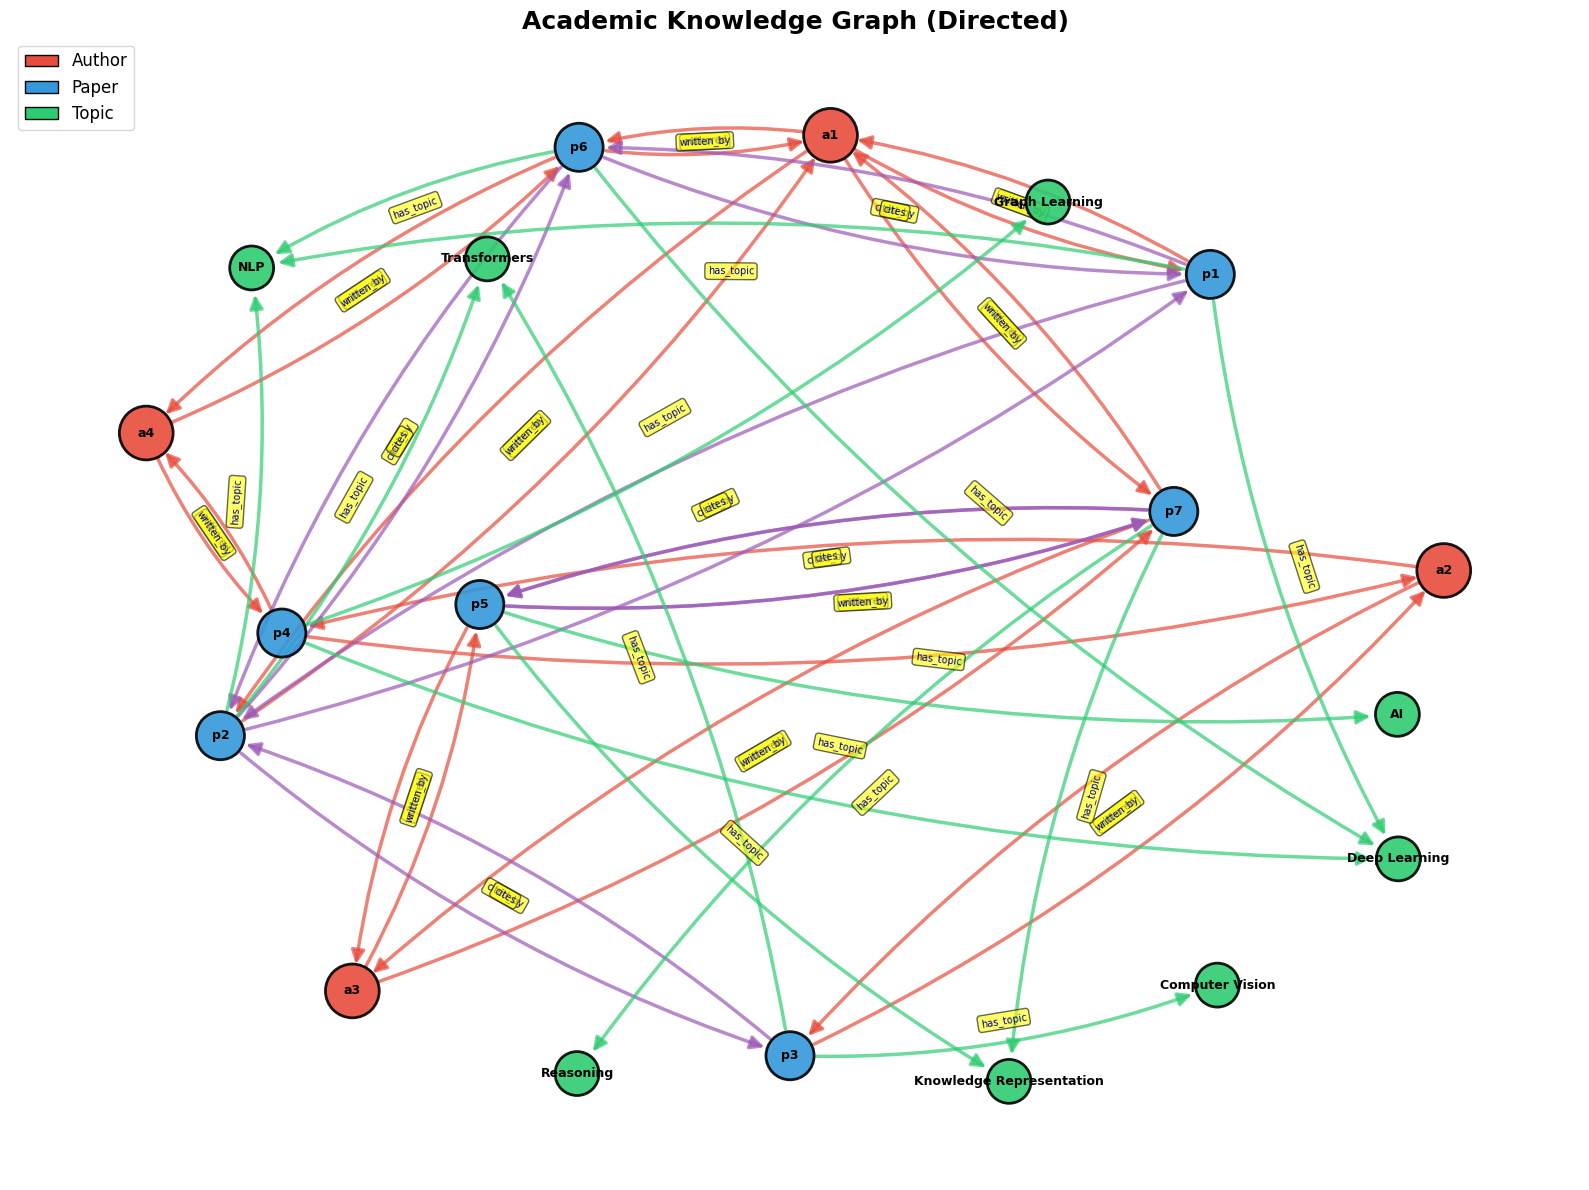

In [44]:
# visualize the knowledge graph
kg = create_sample_knowledge_graph()

# kg.visualize_simple()

# Visualize the full graph
print("\n Visualizing full knowledge graph...")
kg.visualize(show_edge_labels=True)


 Visualizing subgraph around 'a3' (Carol Wang)...


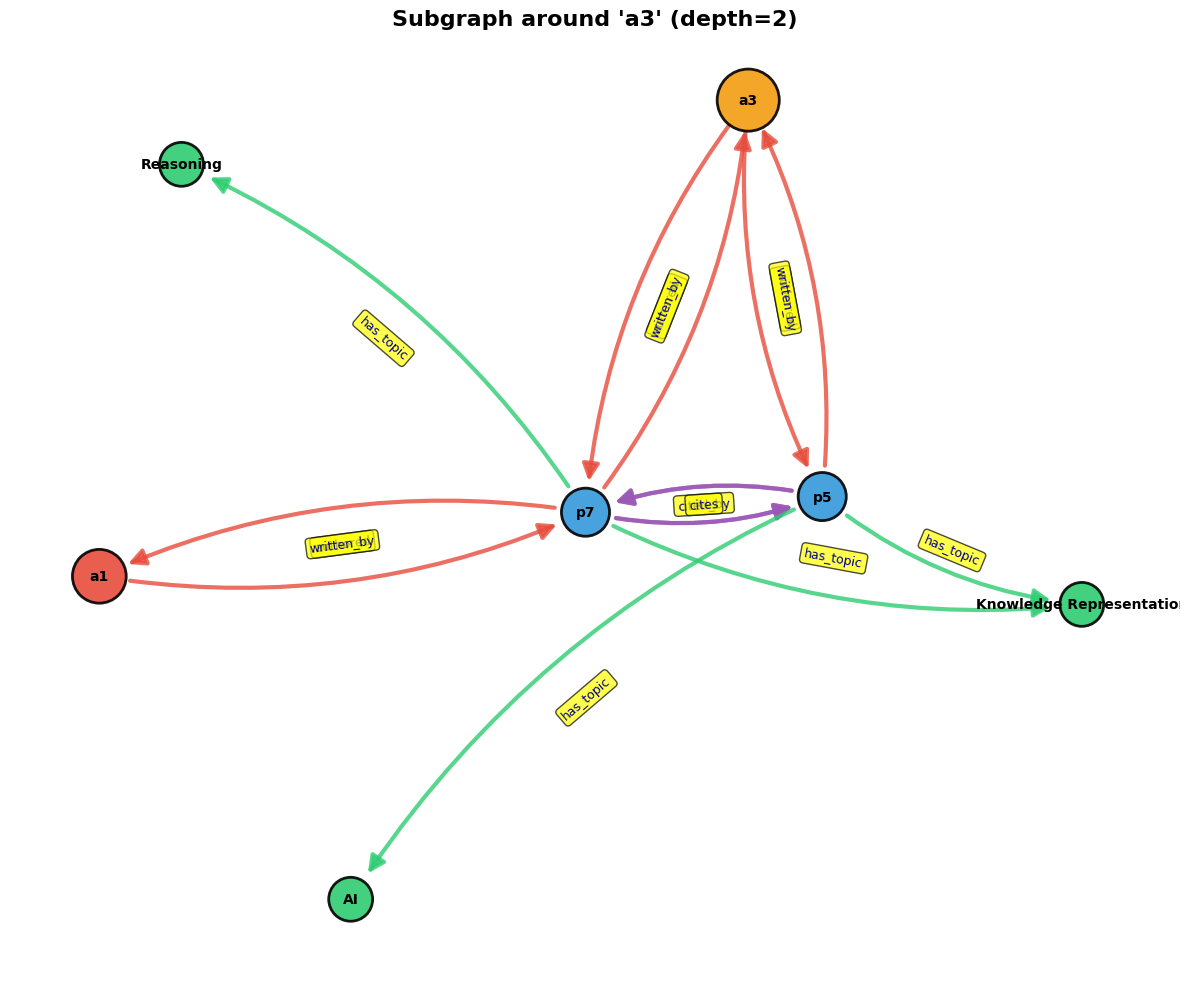

In [45]:
# Visualize a subgraph for clearer directed edges
print("\n Visualizing subgraph around 'a3' (Carol Wang)...")
kg.visualize_subgraph('a3', depth=2)